In [ ]:
 !pip install split-folders
# # !pip install tensorboard jupyter ipywidgets

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from google.colab import drive

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATASET_DIR = "/content/drive/MyDrive/AAI_Dataset/Rice Leaf Disease Images"

In [ ]:
# import splitfolders
# # Split folder into train, test and validation set.
# splitfolders.ratio('/content/drive/MyDrive/AAI_Dataset/Rice Leaf Disease Images/', output="/content/drive/MyDrive/AAI_Dataset/Rice Leaf Disease Images/", seed=1337, ratio=(0.8, 0.1, 0.1))

Copying files: 5942 files [02:52, 34.40 files/s] 


In [4]:
train_dir = DATASET_DIR + "/train"
valid_dir = DATASET_DIR + "/val"
diseases = os.listdir(train_dir)

diseases = [item for item in diseases if item not in {'train', 'val', 'test'}]

# Print dieases name
print(diseases)

['Bacterialblight', 'Brownspot', 'Blast', 'Tungro']


In [5]:
print(f"Total classes are: {len(diseases)}")

Total classes are: 4


In [6]:
nums = {disease: len(os.listdir(os.path.join(train_dir, disease))) for disease in diseases}

# Converting the nums dictionary to pandas DataFrame with plant name as index and number of images as column
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of images"])

img_per_class

,No. of images
Bacterialblight,1275
Brownspot,1280
Blast,1152
Tungro,1046


<Figure size 1000x600 with 0 Axes>

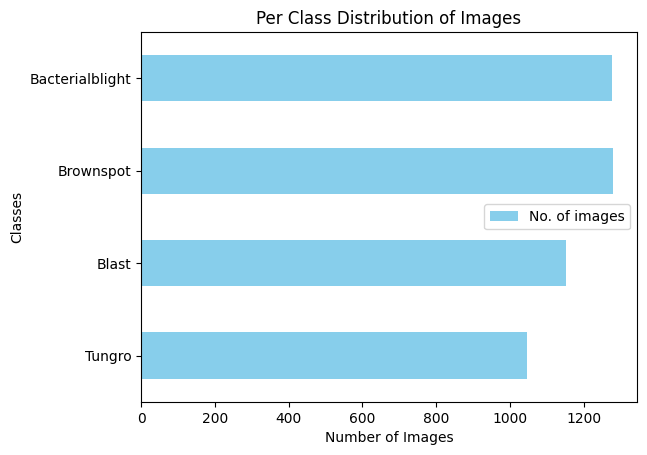

In [7]:
plt.figure(figsize=(10, 6))
img_per_class.plot(kind='barh', color='skyblue')
plt.xlabel('Number of Images')
plt.ylabel('Classes')
plt.title('Per Class Distribution of Images')
plt.gca().invert_yaxis()
plt.show()

In [8]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
def is_valid_file(file_path):
    try:
        # Open the image file
        with open(file_path, 'rb') as f:
            img = Image.open(f)

            # Attempt to load the image to ensure it's valid
            img.load()
             # Verify the integrity of the image file
            img.verify()
            return True
    except Exception as e:
        # If any exception occurs during the process, consider the file as invalid
        return False


In [10]:
batch_size=64

In [11]:
train_dataset = ImageFolder(root='/content/drive/MyDrive/AAI_Dataset/Rice Leaf Disease Images/train', transform=train_transforms,is_valid_file=is_valid_file)
val_dataset = ImageFolder(root='/content/drive/MyDrive/AAI_Dataset/Rice Leaf Disease Images/val', transform=val_transforms,is_valid_file=is_valid_file)
test_dataset = ImageFolder(root='/content/drive/MyDrive/AAI_Dataset/Rice Leaf Disease Images/test', transform=val_transforms,is_valid_file=is_valid_file)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


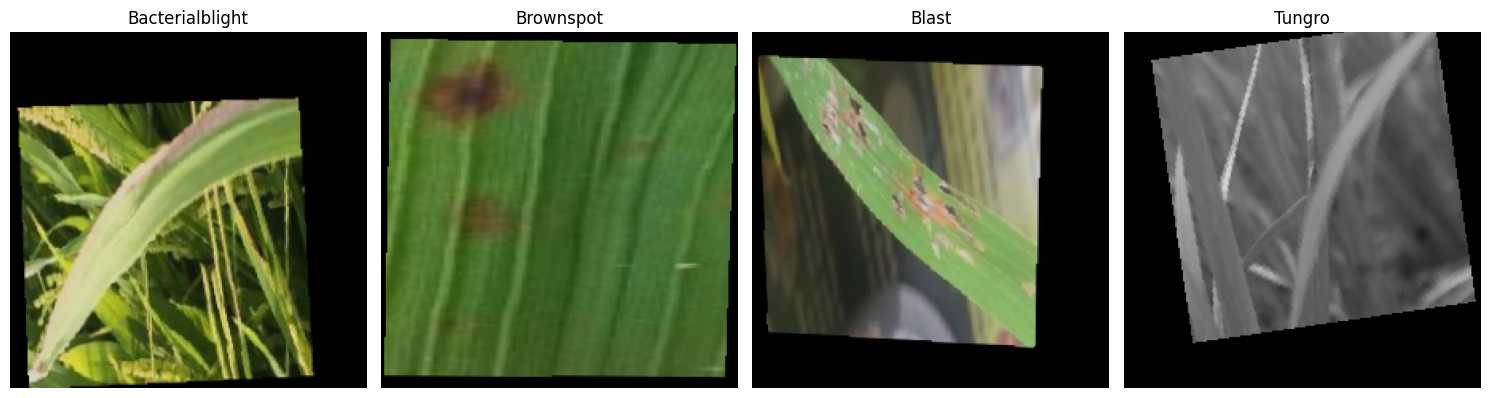

In [13]:
unique_classes = set()
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

num_classes = len(class_to_idx)
num_cols = min(5, num_classes)
num_rows = math.ceil(num_classes / num_cols)

if num_rows == 1:
    fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(15, 5))
else:
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 3))

row_index = 0
col_index = 0

for images, labels in train_loader:
    for image, label in zip(images, labels):
        class_name = idx_to_class[label.item()]
        if class_name not in unique_classes:
            unique_classes.add(class_name)
            if num_rows == 1:
                ax = axes[col_index]
            else:
                ax = axes[row_index, col_index]
            img = image.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis('off')

            col_index += 1
            if col_index == num_cols:
                col_index = 0
                row_index += 1

        if len(unique_classes) == num_classes:
            break
    if len(unique_classes) == num_classes:
        break

plt.tight_layout()
plt.show()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
model = models.vgg19(pretrained=True)
model.to(device)




Device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 74.1MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [16]:
TENSORBOARD_SUMMARY_PATH=f'{DATASET_DIR}/Vgg_Rice_Leaf_Disease_Images'
writer = SummaryWriter(TENSORBOARD_SUMMARY_PATH)

In [17]:
BEST_MODEL_PATH='/content/drive/MyDrive/Vgg_Rice_Leaf_Disease_Images.pth'

In [18]:
early_stopping_patience = 5
epochs_no_improve = 0
val_loss_min = np.Inf

In [20]:
!pip install ptflops

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [21]:
import time
from ptflops import get_model_complexity_info

def train_model(num_epochs):
    global epochs_no_improve
    best_val_loss = float('inf')

    # Calculate MACs using get_model_complexity_info
    macs, _ = get_model_complexity_info(model, (3, 224, 224), as_strings=False,
                                        print_per_layer_stat=False, verbose=False)

    for epoch in range(num_epochs):
        # Train the model
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        start_time = time.time()  # Start time for GFLOPS calculation

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        end_time = time.time()  # End time for GFLOPS calculation

        # Calculate GFLOPS
        elapsed_time = end_time - start_time
        gflops = (macs / elapsed_time) / 1e9

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        writer.add_scalar('Training loss', epoch_loss, epoch)
        writer.add_scalar('Training accuracy', epoch_acc, epoch)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / val_total
        val_accuracy = val_correct / val_total
        writer.add_scalar('Validation loss', val_loss, epoch)
        writer.add_scalar('Validation accuracy', val_accuracy, epoch)

        scheduler.step(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, '
              f'GFLOPS: {gflops:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), BEST_MODEL_PATH)
        else:
            epochs_no_improve += 1

        if epochs_no_improve == early_stopping_patience:
            print('Early stopping initiated...')
            break


In [22]:
num_epochs = 10
train_model(num_epochs)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/10], Train Loss: 1.5313, Train Acc: 0.5232, Val Loss: 0.5245, Val Acc: 0.8129, GFLOPS: 0.8376
Epoch [2/10], Train Loss: 0.5019, Train Acc: 0.8020, Val Loss: 0.2296, Val Acc: 0.9130, GFLOPS: 0.8062
Epoch [3/10], Train Loss: 0.3445, Train Acc: 0.8674, Val Loss: 0.1161, Val Acc: 0.9584, GFLOPS: 0.8015
Epoch [4/10], Train Loss: 0.2647, Train Acc: 0.9061, Val Loss: 0.0852, Val Acc: 0.9660, GFLOPS: 0.7971
Epoch [5/10], Train Loss: 0.2206, Train Acc: 0.9190, Val Loss: 0.0681, Val Acc: 0.9773, GFLOPS: 0.8034
Epoch [6/10], Train Loss: 0.1816, Train Acc: 0.9316, Val Loss: 0.0490, Val Acc: 0.9849, GFLOPS: 0.7996
Epoch [7/10], Train Loss: 0.1618, Train Acc: 0.9445, Val Loss: 0.0081, Val Acc: 1.0000, GFLOPS: 0.7980
Epoch [8/10], Train Loss: 0.1459, Train Acc: 0.9474, Val Loss: 0.0139, Val Acc: 0.9962, GFLOPS: 0.7981
Epoch [9/10], Train Loss: 0.1283, Train Acc: 0.9552, Val Loss: 0.0066, Val Acc: 1.0000, GFLOPS: 0.8551
Epoch [10/10], Train Loss: 0.1265, Train Acc: 0.9552, Val Loss: 0.0073, V

In [23]:
# Model evaluation
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
test_correct = 0
test_total = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_targets.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = test_correct / test_total
print(f'\n\nTest Accuracy: {test_accuracy:.4f}')

writer.close()



Test Accuracy: 0.9981


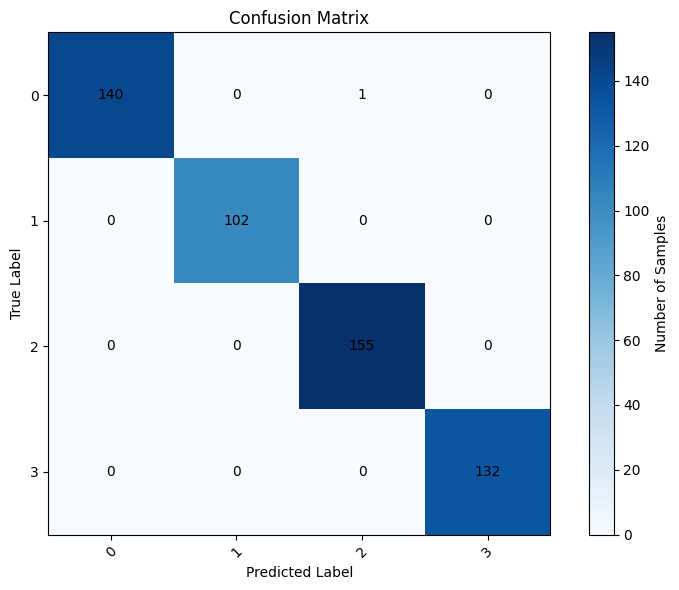

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       141
           1       1.00      1.00      1.00       102
           2       0.99      1.00      1.00       155
           3       1.00      1.00      1.00       132

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530



In [24]:
conf_matrix = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center')

plt.title('Confusion Matrix')
plt.colorbar(label='Number of Samples')
plt.xticks(np.arange(len(conf_matrix)), list(set(all_targets)), rotation=45)
plt.yticks(np.arange(len(conf_matrix)), list(set(all_targets)))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

class_report = classification_report(all_targets, all_predictions)
print("Classification Report:")
print(class_report)

In [ ]:
%load_ext tensorboard
%tensorboard
%tensorboard --logdir {TENSORBOARD_SUMMARY_PATH}

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2024-04-10 03:35:14.110122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 03:35:14.110201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 03:35:14.111567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 03:35:15.204428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Error: A logdir or db must be specified. For example `tensorboard --logdir mylogdir` or `tensorboard --db sqlite:~/.tensorboard.db`. Run `tensorboard --helpfull` for de

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2024-04-10 03:35:18.821665: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 03:35:18.821739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 03:35:18.823035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 03:35:19.904942: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC] [--host ADDR]
                   [--bind_all] [--port PORT] [--reuse_port BOOL] [--load_f

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Create an EventAccumulator object for the SummaryWriter's log directory
event_acc = EventAccumulator(TENSORBOARD_SUMMARY_PATH)
event_acc.Reload()

# Get training and validation scalars
train_loss = [event.value for event in event_acc.Scalars('Training loss')]
train_accuracy = [event.value for event in event_acc.Scalars('Training accuracy')]
val_loss = [event.value for event in event_acc.Scalars('Validation loss')]
val_accuracy = [event.value for event in event_acc.Scalars('Validation accuracy')]

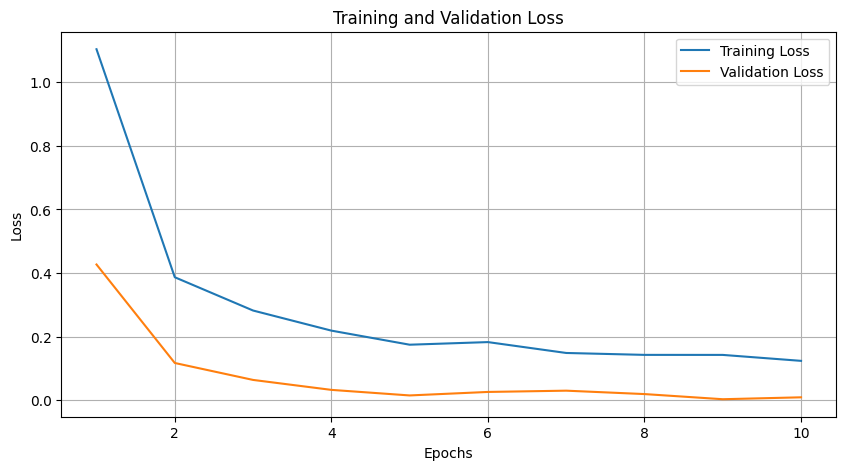

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, len(train_loss) + 1), y=train_loss, label='Training Loss')
sns.lineplot(x=range(1, len(val_loss) + 1), y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

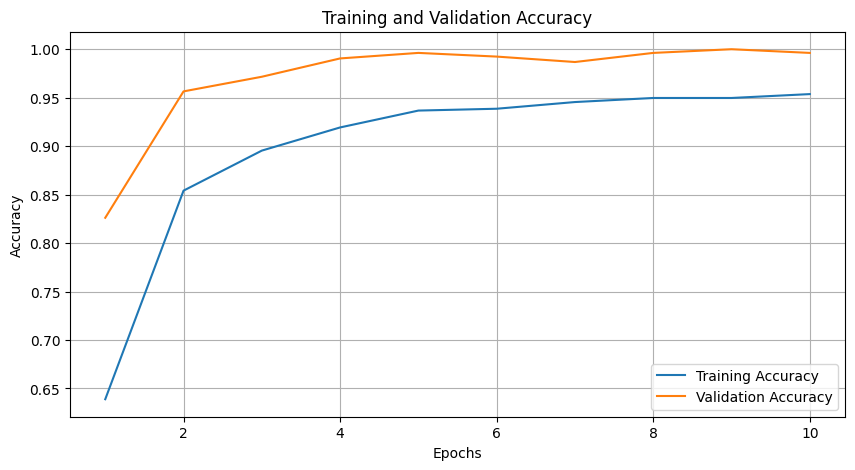

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, len(train_accuracy) + 1), y=train_accuracy, label='Training Accuracy')
sns.lineplot(x=range(1, len(val_accuracy) + 1), y=val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
def extract_features(loader, model, device):
    features = []
    targets = []
    model.eval()
    outputs = None
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            features.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return np.array(features), np.array(targets)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


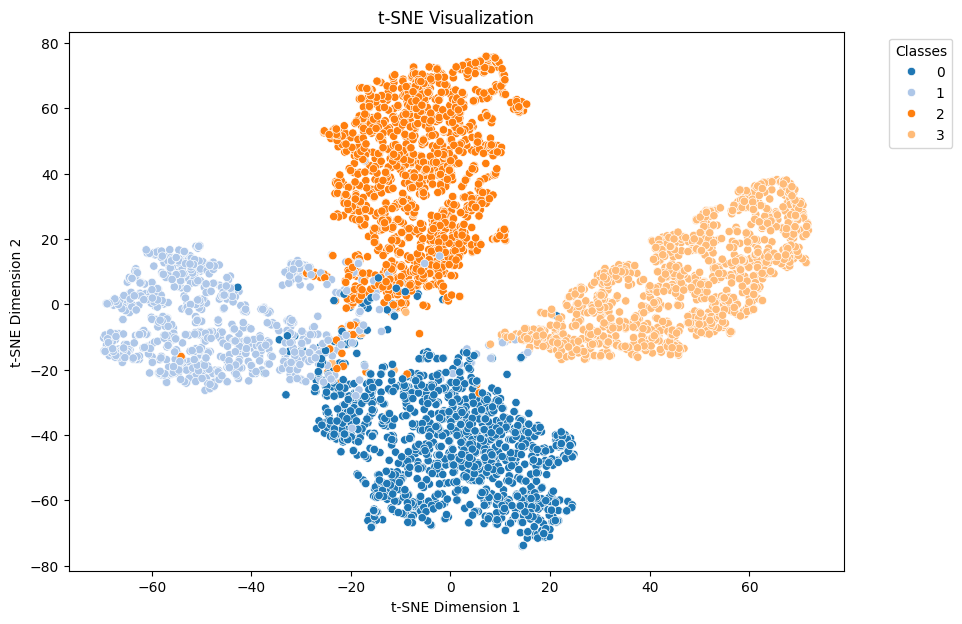

In [ ]:
train_features, train_targets = extract_features(train_loader, model, device)
val_features, val_targets = extract_features(val_loader, model, device)

all_features = np.concatenate((train_features, val_features), axis=0)
all_targets = np.concatenate((train_targets, val_targets), axis=0)

tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(all_features)


plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=all_targets, palette='tab20', legend='full')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()